In [69]:
import pandas as pd
from random import randint, sample
import datetime as dt
import matplotlib.pyplot as plt
import numpy as np

# Import SQL Alchemy
import sqlalchemy
from sqlalchemy.sql import func
from sqlalchemy.orm import Session\

# Import and establish Base for which classes will be constructed 
from sqlalchemy.ext.automap import automap_base
Base = automap_base()

In [2]:
engine = sqlalchemy.create_engine("sqlite:///sql/hawaii.sqlite", echo = False)
session = Session(bind = engine)

In [3]:
Base.prepare(engine, reflect = True)

In [4]:
Base.classes.keys()

['prcp_measurements', 'stations', 'temp_measurements']

In [5]:
conn = engine.connect()
conn.execute("select * from stations").fetchall()

[('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0),
 ('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6),
 ('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0),
 ('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9),
 ('USC00518838', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6),
 ('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5),
 ('USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999995, 32.9),
 ('USC00511918', 'HONOLULU OBSERVATORY 702.2, HI US', 21.3152, -157.9992, 0.9),
 ('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4)]

In [6]:
Measurement = Base.classes.prcp_measurements
Station = Base.classes.stations
Temp_Measurement = Base.classes.temp_measurements

In [7]:
session = sqlalchemy.orm.Session(bind = engine)

In [8]:
for station in session.query(Station):
    print(station.station_id)

USC00519397
USC00513117
USC00514830
USC00517948
USC00518838
USC00519523
USC00519281
USC00511918
USC00516128


In [48]:
#find last data date
data_last_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()[0]
data_last_date

'2017-08-23'

In [51]:
data_start_date_dt = dt.datetime.strptime(data_last_date , "%Y-%m-%d")\
    - dt.timedelta(365)
data_start_date = data_start_date_dt.strftime("%Y-%m-%d")
data_start_date

'2016-08-23'

In [55]:
results = session.query(Measurement).filter(Measurement.date < data_last_date).filter(Measurement.date > data_start_date).all()
prcp_data = {}
for res in results:
    prcp_data[res.measurement_id] = {
        'date': res.date,
        'prcp': res.prcp,
        'station_id': res.station_id
    }
prcp_data[res.measurement_id] 

{'date': '2017-08-22', 'prcp': 0.5, 'station_id': 'USC00516128'}

In [56]:
prcp_df = pd.DataFrame(prcp_data).T
prcp_df.head()

,date,prcp,station_id
2364,2016-08-24,0.08,USC00519397
2365,2016-08-25,0.08,USC00519397
2366,2016-08-26,0,USC00519397
2367,2016-08-27,0,USC00519397
2368,2016-08-28,0.01,USC00519397


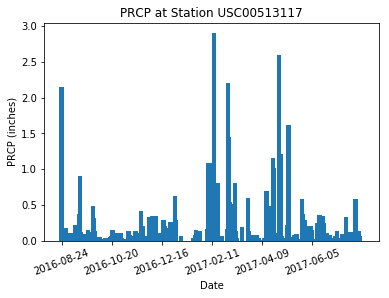

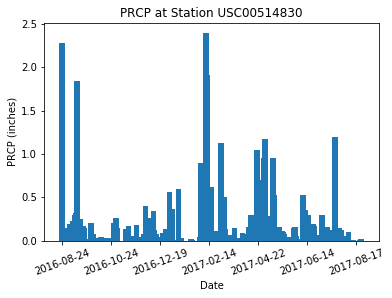

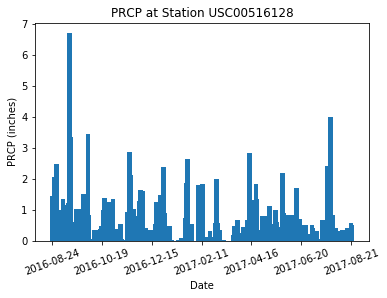

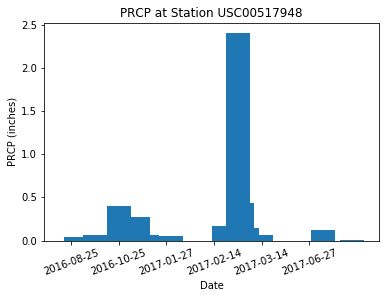

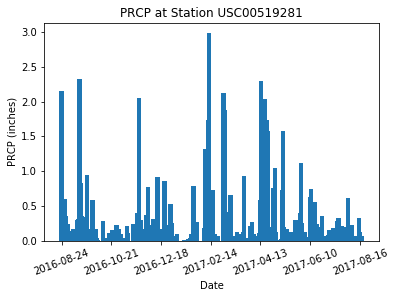

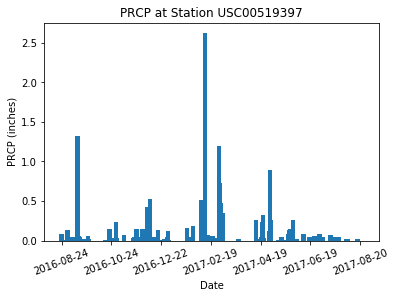

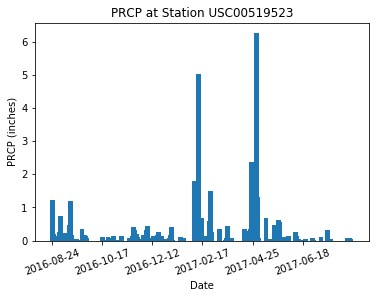

In [106]:
for station, dat in prcp_df.groupby("station_id"):
    plt.bar(dat['date'], dat['prcp'], label = station, width = 5)
    plt.title('PRCP at Station ' + station)
    plt.ylabel('PRCP (inches)')
    dates = dat['date'].count() #length of data
    arange = np.arange(0,dates-1, int(dates/6)) #pick 6 dates for tickmarks
    labels = [dat['date'].tolist()[tick] for tick in arange] #date for each tick

    plt.xticks(arange, labels, rotation = 20)
    plt.xlabel('Date')
    plt.show()
#plt.legend(loc = 'best')
#plt.show()

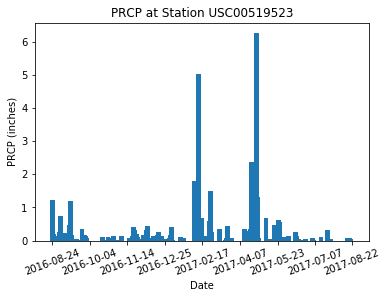

In [104]:
#for testing without looping

'''plt.bar(dat['date'], dat['prcp'], label = station, width = 5)
plt.title('PRCP at Station ' + station)
plt.ylabel('PRCP (inches)')
dates = dat['date'].count() #length of data
arange = np.arange(0,dates-1, int(dates/8)) #pick 8 dates for tickmarks
labels = [dat['date'].tolist()[tick] for tick in arange] #date for each tick
arange = np.append(arange,(dates-1)) #add on an end date
labels.append(dat['date'].tolist()[dates-1])
plt.xticks(arange, labels, rotation = 20)
plt.xlabel('Date')
plt.show()'''

In [86]:
station_entries_df = prcp_df.groupby("station_id").count().sort_values('prcp', ascending = False)[["date"]].rename(columns = {"date": "# entries"})
station_entries_df
#temp_results.group_by("station_id")

,# entries
station_id,
USC00519397,357
USC00519281,351
USC00513117,342
USC00516128,326
USC00519523,312
USC00514830,263
USC00517948,60


In [87]:
top_station_id = station_entries_df.reset_index().loc[0,"station_id"]
print("The station with the most observations is station", top_station_id)
top_station_loc = session.query(Station.name).filter(Station.station_id == top_station_id).first()[0]
print("Location -", top_station_loc)

The station with the most observations is station USC00519397
Location - WAIKIKI 717.2, HI US


In [88]:
stations_in_Station = session.query(Station).count()
print("Number of Stations in Station Table -", stations_in_Station)
stations_in_data = session.query(Measurement).group_by("station_id").count()
print("Number of Stations in data tables should be the same -", stations_in_data, end = " - ")
if stations_in_Station == stations_in_data:
    print("and is the same")
else:
    print("but is not", end = " ")
if stations_in_data > stations_in_Station:
    print("and that is a problem since the station data cannot map fully onto the overall data")

Number of Stations in Station Table - 9
Number of Stations in data tables should be the same - 9 - and is the same


In [89]:
data_first_date = session.query(Measurement.date).order_by(Measurement.date).first()
data_first_date

('2010-01-01')

In [90]:
data_last_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
data_last_date

('2017-08-23')

In [91]:
analysis_length = 365
analysis_end = dt.datetime.strptime(data_last_date[0] , "%Y-%m-%d")
analysis_begin = dt.datetime.strptime(data_last_date[0] , "%Y-%m-%d") - dt.timedelta(analysis_length)

In [92]:
#get all of prcp data within last year for most prominent station
prcp_results = session.query(Measurement)\
    .filter(Measurement.date > analysis_begin)\
    .filter(Measurement.date < analysis_end)\
    .filter(Temp_Measurement.station_id == top_station_id)
#populating dictionary for precipitation data for plotting, etc
prcp_data = {}
for result in prcp_results:
    prcp_data[result.measurement_id] = {"date": result.date, "station_id": result.station_id, "prcp": result.prcp}
    

In [93]:
#same as above but for temps, should be longer since temp data is more complete
temp_results = session.query(Temp_Measurement)\
    .filter(Temp_Measurement.date > analysis_begin)\
    .filter(Temp_Measurement.date < analysis_end)\
    .filter(Temp_Measurement.station_id == top_station_id)
#populating dictionary for temperature data for plotting, etc
temp_data = {}
for result in temp_results:
    temp_data[result.measurement_id] = {"date": result.date, "station_id": result.station_id, "temp": result.tobs}
    

In [94]:
temp_df = pd.DataFrame(temp_data).T
temp_df.head()
temps_list = []
for m_id in temp_data:
    temps_list.append(temp_data[m_id]["temp"])

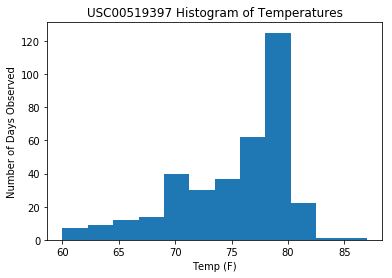

In [96]:
#temp_df = pd.DataFrame(temp_data).T

plt.hist(temps_list, bins = 12)
plt.title(top_station_id + " Histogram of Temperatures")
plt.xlabel('Temp (F)')
plt.ylabel('Number of Days Observed')
plt.show()